In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from joblib import dump, load
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, F1Score
from keras.layers import Dense, Dropout
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('spooky_cleaned.csv')
df.head()

Saving spooky_cleaned.csv to spooky_cleaned.csv


,id,text,author,space_tokenized_text,rule_tokenized_text,wordpiece_tokenized_text
0,id26305,proces however afforded means ascertaining dim...,EAP,"['proces', 'however', 'afforded', 'means', 'as...","['proces', 'however', 'afforded', 'means', 'as...","['[CLS]', 'pro', '##ces', 'however', 'afforded..."
1,id17569,never occurred fumbling might mere mistake,HPL,"['never', 'occurred', 'fumbling', 'might', 'me...","['never', 'occurred', 'fumbling', 'might', 'me...","['[CLS]', 'never', 'occurred', 'fu', '##mbling..."
2,id11008,left hand gold snuff box capered hil cutting m...,EAP,"['left', 'hand', 'gold', 'snuff', 'box', 'cape...","['left', 'hand', 'gold', 'snuff', 'box', 'cape...","['[CLS]', 'left', 'hand', 'gold', 's', '##nu',..."
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,"['lovely', 'spring', 'looked', 'windsor', 'ter...","['lovely', 'spring', 'looked', 'windsor', 'ter...","['[CLS]', 'lovely', 'spring', 'looked', 'winds..."
4,id12958,finding nothing else even gold superintendent ...,HPL,"['finding', 'nothing', 'else', 'even', 'gold',...","['finding', 'nothing', 'else', 'even', 'gold',...","['[CLS]', 'finding', 'nothing', 'else', 'even'..."


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
X = df['text']
y = df['author']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [4]:
X = df['text']
y = df['author']
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X)
X_train_tfidf = X_train_tfidf.toarray()

In [5]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [6]:
import keras_tuner
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.optimizers import Adam

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        units_1 = hp.Choice('layer_1', values=[32, 64, 128])
        model.add(Dense(units_1, activation='tanh', input_shape=X_train_tfidf.shape[1:]))

        units_2 = hp.Choice('layer_2', values=[32, 64, 128])
        model.add(Dense(units_2, activation='tanh'))

        num_classes = y.shape[-1]
        model.add(Dense(num_classes, activation='softmax'))

        optimizer = Adam(
            hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-3)
        )

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, **kwargs)

tuner = keras_tuner.RandomSearch(
    objective='val_accuracy',
    executions_per_trial=2,
    max_trials=20,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="tp3",
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
tuner.search(X_train_tfidf, y, epochs=20, validation_split=0.33)


Trial 20 Complete [00h 02m 03s]
val_accuracy: 0.8276582658290863

Best val_accuracy So Far: 0.8294381499290466
Total elapsed time: 00h 41m 35s


In [8]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'layer_1': 128, 'layer_2': 64, 'learning_rate': 3.161391335908762e-05}

In [9]:
#make a model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

model.compile(optimizer=Adam(best_hps.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

#train the model and capture loss and accuracy
history = model.fit(X_train_tfidf, y, epochs=15, validation_split=0.33)

Epoch 1/15
410/410 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3983 - f1_score: 0.2834 - loss: 1.0909 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4069 - val_f1_score: 0.1973 - val_loss: 1.0624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4214 - f1_score: 0.2260 - loss: 1.0386 - precision: 0.0900 - recall: 3.7804e-05 - val_accuracy: 0.4973 - val_f1_score: 0.3802 - val_loss: 0.9893 - val_precision: 1.0000 - val_recall: 0.0059
Epoch 3/15
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6215 - f1_score: 0.5729 - loss: 0.9271 - precision: 0.9950 - recall: 0.0613 - val_accuracy: 0.7375 - val_f1_score: 0.7293 - val_loss: 0.8616 - val_precision: 0.9682 - val_recall: 0.2212
Epoch 4/15
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8537 - f1_score: 0.8543 - loss: 0.7534 - precision: 0.9866 - recall: 0.4145 - val_accuracy: 0.7976 - val_f1_score: 0.7956 - val_loss: 0.7206 - val_precision:

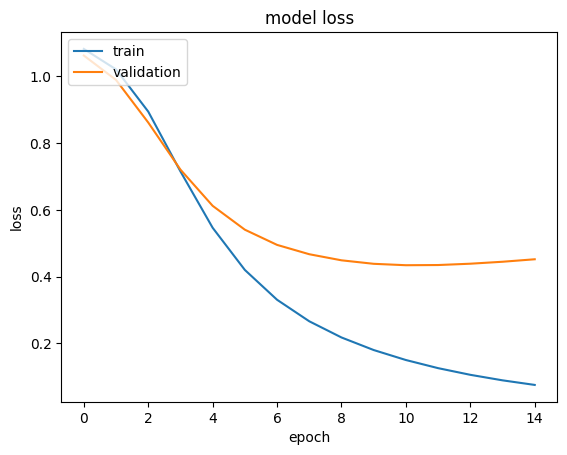

In [10]:
#plot the training loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

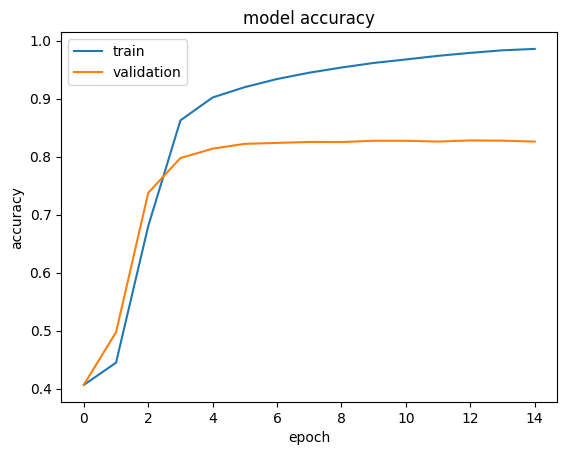

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
#calculate the best validation accuracy, precision, recall and f1 score
val_accuracy = max(history.history['val_accuracy'])
val_precision = np.mean(history.history['val_precision'])
val_recall = max(history.history['val_recall'])
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-9)

print(f'Validation accuracy: {val_accuracy}')
print(f'Validation precision: {val_precision}')
print(f'Validation recall: {val_recall}')
print(f'Validation f1 score: {val_f1_score}')

Validation accuracy: 0.8278903961181641
Validation precision: 0.8252391616503397
Validation recall: 0.810555636882782
Validation f1 score: 0.817831496276939


In [14]:
#save the model and history
model.save('model.h5')
dump(history.history, 'history.joblib')

['history.joblib']